# Visual Citations with LlamaParse Layout Agent Mode

<a href="https://colab.research.google.com/github/run-llama/llama_cloud_services/blob/main/examples/parse/parsing_modes/demo_layout_agent_mode_visual_citations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cookbook will show you how to leverage LlamaParse's new Layout Agent mode to build a query engine that provides visually grounded citations. But first—what exactly is Layout Agent mode?

## Layout Agent Mode

This new mode will parse pages in a layout-aware way. Instead of treating a page as plain text, Layout Agent sees the document structure and breaks it into visual blocks such as text, lists, figures, and tables. Each block is then parsed using the most suitable AI model.

![Layout parsing moe](https://github.com/run-llama/llama_cloud_services/blob/main/examples/parse/parsing_modes/layout_agent_moe.png?raw=1)

It is harder to parse a chart than just transcribing text. That's why Layout Agent mode will use bigger/more expensive models for hard tasks and lighter/more efficient models for more naive and simple tasks.

- 🟢 Easy to parse → Uses lightweight, general models
- 🟡 Moderate difficulty → Uses specialized, efficient models
- 🔴 Hard to parse → Uses larger, more capable models

This Mixture of Experts approach ensures both efficiency and accuracy, allocating resources where they’re needed most.

### Visually Grounded Parsing
![Layout Agent explainer](https://github.com/run-llama/llama_cloud_services/blob/main/examples/parse/parsing_modes/layout_agent_parse_explainer.png?raw=1)

One of the most powerful features of Layout Agent mode is that every extracted Markdown block includes a bounding box, a visual reference that shows exactly where the information came from on the page.

With visual references, you can build applications that preserve document structure and provide users with trustworthy, traceable visual citations. We will now leverage this feature to build our query engine.

# Query Engine with Visual Citations

![query engine with visual citations illustrations](https://github.com/run-llama/llama_cloud_services/blob/main/examples/parse/parsing_modes/layout_agent_citation_engine.png?raw=1)

Now, let's build a [query engine](https://docs.llamaindex.ai/en/stable/module_guides/deploying/query_engine/) that provides **visually grounded answers** from a financial report by the International Monetary Fund (IMF).

By the end of this cookbook, you'll be able to:
- ✅ Ask questions about the document
- ✅ Receive answers with citations
- ✅ See exactly where the information came from

First, [get an api key](https://docs.cloud.llamaindex.ai/llamaparse/getting_started/get_an_api_key) and set it as an environment variable.

In [ ]:
import os

os.environ["LLAMA_CLOUD_API_KEY"] = "LLAMA_CLOUD_API_KEY"

Now install the required packages:

In [3]:
%pip install llama-cloud-services llama-index-core nest_asyncio

  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.3.6
    Uninstalling platformdirs-4.3.6:
      Successfully uninstalled platformdirs-4.3.6
  Attempting uninstall: llama-cloud
    Found existing installation: llama-cloud 0.0.17
    Uninstalling llama-cloud-0.0.17:
      Successfully uninstalled llama-cloud-0.0.17

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Now that we have our API key and libraries available, let's setup our parser and allow nested async loops:

In [4]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio

nest_asyncio.apply()

In [6]:
from llama_cloud_services import LlamaParse

parser = LlamaParse(parse_mode="parse_page_with_layout_agent")

We will parse the PDF file and return the JSON output.

In [8]:
parsed_pdf = parser.get_json_result("./gpt4all.pdf")

Started parsing the file under job_id 16517216-1752-42f2-bf53-4b741fd2b516


Our report is now parsed and in JSON format, let's convert this into a list of Documents. We also save the bbox along with the text and page index.

In [9]:
from llama_index.core import Document

pages = parsed_pdf[0]["pages"]
documents = []

for i, page in enumerate(pages):
    # loop trough items of the page
    for item in page["items"]:
        document = Document(
            text=item["md"], extra_info={"bbox": item["bBox"], "page": i}
        )
        documents.append(document)

In [10]:
#parsed_pdf

In [11]:
len(pages)

6

In [12]:
len(documents)

97

In [13]:
documents[25]

Document(id_='4db8ca21-12c6-4f64-859e-48cbfcddd5ae', embedding=None, metadata={'bbox': {'x': 304.78, 'y': 593.53, 'w': 220.85, 'h': 141.44}, 'page': 0}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='To train the original GPT4All model, we collected roughly one million prompt-response pairs using the GPT-3.5-Turbo OpenAI API between March 20, 2023 and March 26th, 2023. In particular, we gathered GPT-3.5-Turbo responses to prompts of three publicly available datasets: the unified chip2 subset of LAION OIG, a random sub-sample of Stackoverflow Questions, and a sub-sample of Bigscience/P3 (Sanh et al., 2021). Following the approach in Stanford Alpaca (Taori et al., 2023), an open source LLAMA variant that came just before GPT4All, we focused substantial effort on dataset curation.', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n')

## RAG ( querying )

Let's go a step further, and query this report using an LLM! For this, you will need an OpenAI API key (LlamaIndex supports many LLMs, we're just picking a popular one). Get an OpenAI API key and add it to your environment variables.

In [ ]:
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"

We'll also need to encode the documents into an index:

In [15]:
%pip install llama-index-llms-openai llama-index-embeddings-openai


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
from llama_index.core import VectorStoreIndex

# create an index from the parsed documents
index = VectorStoreIndex.from_documents(documents)

We are almost done, let's query this index using `CitationQueryEngine`. This engine will give answers and also returns the cited nodes.

In [17]:
from llama_index.core.query_engine import CitationQueryEngine

query_engine = CitationQueryEngine.from_args(index, similarity_top_k=3)

Let's query our document!

In [18]:
response = query_engine.query(
    "What is BoolQ value of Falcon 7B instruct?"
)
print(response.response)

The BoolQ value of Falcon 7B instruct is 70.9 [2].


We can see that the LLM is citing the source number 2, let's first extract it from the source nodes:

In [19]:
# llm citations are 1 indexed (source 2 -> index 1)
citation = response.source_nodes[1]

# get the visual bbox and the page number of the citation
bbox = citation.node.metadata["bbox"]
page_index = citation.node.metadata["page"]

It's time to visualize this citation! We will use pymupdf to take a screenshot of the page and display the citation.

In [20]:
%pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 48.2 MB/s eta 0:00:0031m45.3 MB/s eta 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import fitz
from PIL import Image

# load page of the pdf
pdf = fitz.open("./gpt4all.pdf")
page = pdf[page_index]

# take screenshot of the page
pix = page.get_pixmap(dpi=200)
image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

# resize the page to align the bbox coordinates
parsed_page = pages[page_index]
image = image.resize((int(parsed_page["width"]), int(parsed_page["height"])))

Finally, we can visually see the citation of the LLM. In this case, it cited the table that contained the answer.

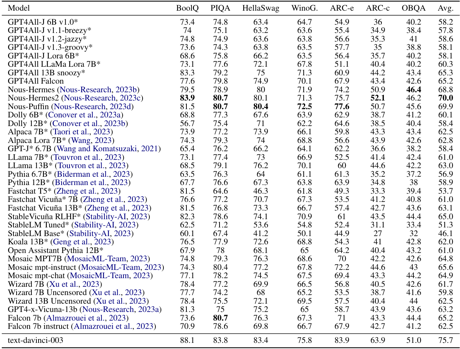

In [24]:
image.crop((bbox["x"], bbox["y"], (bbox["x"] + bbox["w"]), (bbox["y"] + bbox["h"])))